## References:
- https://arxiv.org/pdf/2004.11362.pdf
- https://towardsdatascience.com/contrastive-loss-for-supervised-classification-224ae35692e7

## Initial setup

In [26]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip install wandb
import wandb
wandb.login()

In [0]:
import os
os.environ['WANDB_DISABLE_CODE'] = 'True'


In [0]:
!wget https://raw.githubusercontent.com/wangz10/contrastive_loss/master/losses.py

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import losses
import cv2
from imutils import paths
tf.random.set_seed(666)
np.random.seed(666)



# ImageNet Subset


In [0]:
!git clone https://github.com/thunderInfy/imagenet-5-categories


In [0]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))


In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [10]:

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)


(1250, 128, 128, 3) (1250,)



(250, 128, 128, 3) (250,)


In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)


In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

## Model building

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = True

	embeddings = encoder(inputs, training=True)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
	projector = tf.keras.models.Sequential([
		Dense(256, activation="relu"),
		UnitNormLayer()
	])

	return projector

## SGD with lr decay function

### Training the encoder and the projector

In [0]:
#SGD with lr decay function


decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.225
Epoch: 10 Loss: 0.098
Epoch: 20 Loss: 0.061
Epoch: 30 Loss: 0.007
Epoch: 40 Loss: 0.004
Epoch: 50 Loss: 0.003



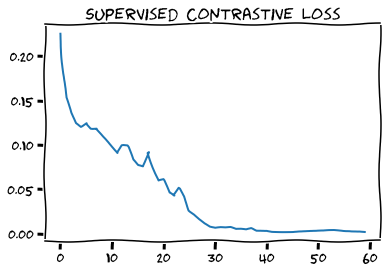

[<tf.Tensor: shape=(), dtype=float32, numpy=0.22536202>, <tf.Tensor: shape=(), dtype=float32, numpy=0.15345898>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1361714>, <tf.Tensor: shape=(), dtype=float32, numpy=0.124779366>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12070365>, <tf.Tensor: shape=(), dtype=float32, numpy=0.12520526>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11915876>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1195793>, <tf.Tensor: shape=(), dtype=float32, numpy=0.11309008>, <tf.Tensor: shape=(), dtype=float32, numpy=0.10596409>, <tf.Tensor: shape=(), dtype=float32, numpy=0.098213375>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09079232>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09930573>, <tf.Tensor: shape=(), dtype=float32, numpy=0.09857245>, <tf.Tensor: shape=(), dtype=float32, numpy=0.083376065>, <tf.Tensor: shape=(), dtype=float32, numpy=0.07710306>, <tf.Tensor: shape=(), dtype=float32, numpy=0.07585727>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0

In [0]:
import time

wandb.init(project="scl", entity="authors",id='SCL_SGD_LRDECAY')
EPOCHS = 60
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

### Training the Supervised Model





In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [0]:
from wandb.keras import WandbCallback

In [0]:
optimizer2 = tf.keras.optimizers.SGD(learning_rate=1e-3)

In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors", id='FSL_SGD_LRDECAY ')

start = time.time()
supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/100
20/20 [==============================] - 6s 285ms/step - loss: 1.6085 - sparse_categorical_accuracy: 0.3888 - val_loss: 1.6079 - val_sparse_categorical_accuracy: 0.3600
Epoch 2/100
20/20 [==============================] - 4s 209ms/step - loss: 1.6063 - sparse_categorical_accuracy: 0.4024 - val_loss: 1.6067 - val_sparse_categorical_accuracy: 0.3640
Epoch 3/100
20/20 [==============================] - 4s 188ms/step - loss: 1.6042 - sparse_categorical_accuracy: 0.4216 - val_loss: 1.6055 - val_sparse_categorical_accuracy: 0.3640
Epoch 4/100
20/20 [==============================] - 4s 209ms/step - loss: 1.6020 - sparse_categorical_accuracy: 0.4376 - val_loss: 1.6042 - val_sparse_categorical_accuracy: 0.3800
Epoch 5/100
20/20 [==============================] - 4s 203ms/step - loss: 1.5998 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.6030 - val_sparse_categorical_accuracy: 0.3800
Epoch 6/100
20/20 [==============================] - 4s 196ms/step - loss: 1.5977 - sparse_cate

## SGD with learning rate=1e-3

### Training the encoder and the projector

In [0]:
optimizer3=tf.keras.optimizers.SGD(learning_rate=1e-3)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer3.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.282
Epoch: 10 Loss: 0.163
Epoch: 20 Loss: 0.161
Epoch: 30 Loss: 0.160
Epoch: 40 Loss: 0.160
Epoch: 50 Loss: 0.158
Epoch: 60 Loss: 0.160
Epoch: 70 Loss: 0.158
Epoch: 80 Loss: 0.157
Epoch: 90 Loss: 0.159



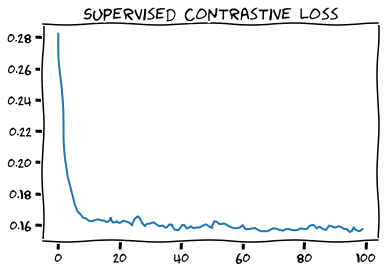

[<tf.Tensor: shape=(), dtype=float32, numpy=0.28230906>, <tf.Tensor: shape=(), dtype=float32, numpy=0.24346034>, <tf.Tensor: shape=(), dtype=float32, numpy=0.21351707>, <tf.Tensor: shape=(), dtype=float32, numpy=0.19083342>, <tf.Tensor: shape=(), dtype=float32, numpy=0.18154323>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17307524>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1684182>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16657326>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16434485>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16394277>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16264112>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16241492>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16348392>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16395937>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16346261>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1631771>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16231243>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1648

In [0]:
import time

wandb.init(project="scl", entity="authors",id='SCL_SGD_LR_0.001_100')
EPOCHS = 100
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

### Training the Supervised Model


In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [0]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer3,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors", id='FSL_SGD_LR_0.001 ')

start = time.time()
supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.6088 - sparse_categorical_accuracy: 0.1976

wandb: Network error resolved after 0:00:17.550744, resuming normal operation.


20/20 [==============================] - 5s 249ms/step - loss: 1.6088 - sparse_categorical_accuracy: 0.1976 - val_loss: 1.6082 - val_sparse_categorical_accuracy: 0.2000
Epoch 2/100
20/20 [==============================] - 4s 186ms/step - loss: 1.6087 - sparse_categorical_accuracy: 0.1992 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.2000
Epoch 3/100
20/20 [==============================] - 4s 208ms/step - loss: 1.6087 - sparse_categorical_accuracy: 0.1976 - val_loss: 1.6081 - val_sparse_categorical_accuracy: 0.2000
Epoch 00003: early stopping


# Adding augmentation

### Preparing dataset

In [0]:
#Random Augmentations

def aug(image, label):
  x=tf.image.random_brightness(image,max_delta=0)
  x=tf.image.random_contrast(x,lower=0.2, upper=1.8)
  x = tf.image.random_saturation(x, lower=0.2, upper=1.5)
  x = tf.image.random_hue(x, max_delta=0.4)
  x = tf.clip_by_value(x, 0, 1)

  return x, label

In [0]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_enc))
validation_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_enc))

In [0]:
IMG_SHAPE = 128
BS = 64
AUTO = tf.data.experimental.AUTOTUNE
train_ds = (
    train_ds
    .shuffle(100)
    .batch(BS)
    .map(aug, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)
validation_ds = (
    validation_ds
    .shuffle(100)
    .batch(BS)
    .prefetch(AUTO)
)

### Training the encoder and decoder

In [0]:
decay_steps = 1000
lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.001, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

In [0]:
encoder_r = encoder_net()
projector_z = projector_net()

@tf.function
def train_step(images, labels):
	with tf.GradientTape() as tape:
		r = encoder_r(images, training=True)
		z = projector_z(r, training=True)
		loss = losses.max_margin_contrastive_loss(z, labels)

	gradients = tape.gradient(loss, 
		encoder_r.trainable_variables + projector_z.trainable_variables)
	optimizer.apply_gradients(zip(gradients, 
		encoder_r.trainable_variables + projector_z.trainable_variables))

	return loss

Epoch: 0 Loss: 0.286
Epoch: 10 Loss: 0.161
Epoch: 20 Loss: 0.164
Epoch: 30 Loss: 0.160
Epoch: 40 Loss: 0.162
Epoch: 50 Loss: 0.160
Epoch: 60 Loss: 0.160
Epoch: 70 Loss: 0.161
Epoch: 80 Loss: 0.160
Epoch: 90 Loss: 0.160



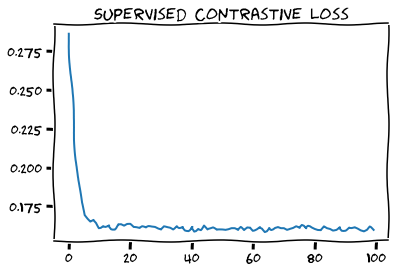

[<tf.Tensor: shape=(), dtype=float32, numpy=0.2864114>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2484008>, <tf.Tensor: shape=(), dtype=float32, numpy=0.2163858>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1921737>, <tf.Tensor: shape=(), dtype=float32, numpy=0.17742871>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1692873>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16700134>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16526209>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16651778>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16454865>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16127811>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16278704>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16243003>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16335031>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16063929>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16060445>, <tf.Tensor: shape=(), dtype=float32, numpy=0.16379017>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1638208

In [19]:
import time

wandb.init(project="scl", entity="authors", id='SCL_SGD_LRDECAY_AUG_100')
EPOCHS = 100
LOG_EVERY = 10
train_loss_results = []

start = time.time()
for epoch in tqdm(range(EPOCHS)):	
	epoch_loss_avg = tf.keras.metrics.Mean()
	
	for (images, labels) in train_ds:
		loss = train_step(images, labels)
		epoch_loss_avg.update_state(loss) 

	train_loss_results.append(epoch_loss_avg.result())
	wandb.log({"supervised_contrastive_loss": epoch_loss_avg.result()})

	if epoch % LOG_EVERY == 0:
		print("Epoch: {} Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

end = time.time()
wandb.log({"training_time": end - start})

with plt.xkcd():
    plt.plot(train_loss_results)
    plt.title("Supervised Contrastive Loss")
    plt.show()
print(train_loss_results)

### Trainig Supervised model

In [0]:
def supervised_model():
	inputs = Input((IMG_SHAPE, IMG_SHAPE, 3))
	encoder_r.trainable = False

	r = encoder_r(inputs, training=False)
	outputs = Dense(5, activation='softmax')(r)

	supervised_model = Model(inputs, outputs)
  
	return supervised_model


In [25]:
supervised_classifier = supervised_model()

supervised_classifier.compile(optimizer=optimizer2,
	loss=tf.keras.losses.SparseCategoricalCrossentropy(),
	metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

es = tf.keras.callbacks.EarlyStopping(monitor="val_sparse_categorical_accuracy", patience=2,
	restore_best_weights=True, verbose=2)

wandb.init(project="scl", entity="authors", id='FSL_SGD_LRDECAY_AUG ')

start = time.time()
supervised_classifier.fit(train_ds,
	validation_data=validation_ds,
	epochs=100,
	callbacks=[WandbCallback(),es])
end = time.time()
wandb.log({"training_time": end - start})

Epoch 1/100


Streaming file created twice in same run: /content/wandb/run-20200528_220030-FSL_SGD_LRDECAY_AUG /wandb-events.jsonl


20/20 [==============================] - 4s 198ms/step - loss: 1.6106 - sparse_categorical_accuracy: 0.1776 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.1840
Epoch 2/100
20/20 [==============================] - 3s 141ms/step - loss: 1.6106 - sparse_categorical_accuracy: 0.1776 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.1840
Epoch 3/100
20/20 [==============================] - 3s 146ms/step - loss: 1.6106 - sparse_categorical_accuracy: 0.1728 - val_loss: 1.6108 - val_sparse_categorical_accuracy: 0.1840
Epoch 00003: early stopping
